# 김형준 박사님 논문 네트워크 구현
- A novel deep learning-based forecasting model optimized by heuristic algorithm for energy management of microgrid, Applied Energy, 332 (2023)

## LSTM+GAM 구조
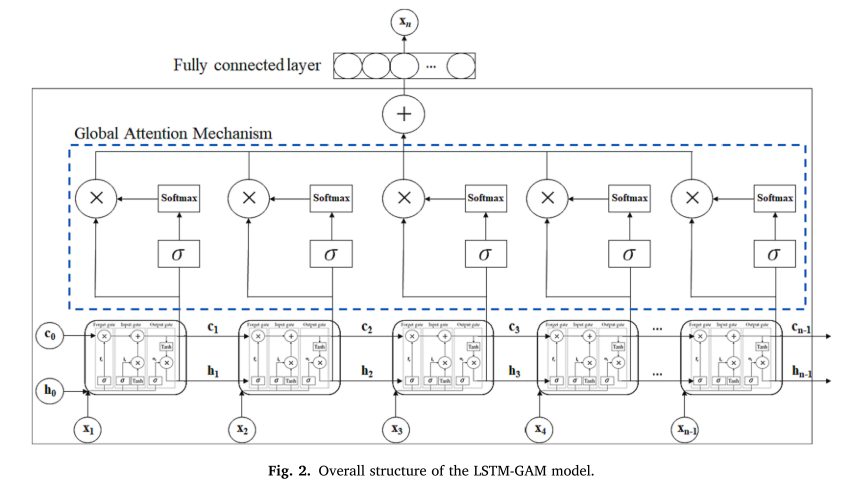
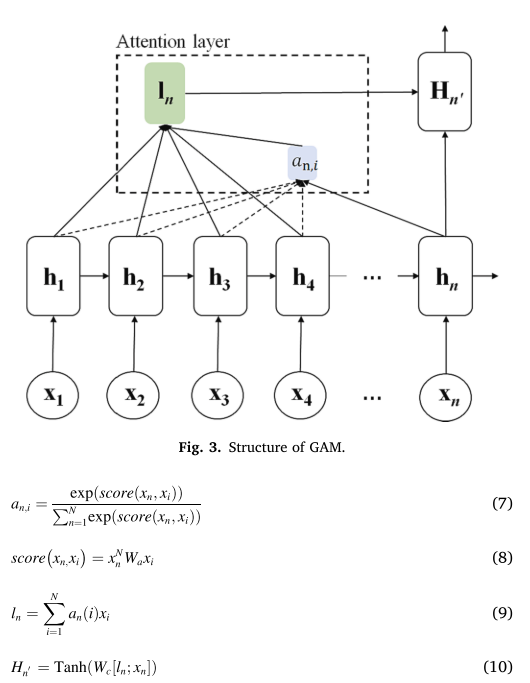

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
# LSTM 네트워크 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size  # 은닉 상태의 크기 설정
        self.num_layers = num_layers  # LSTM 레이어의 수 설정
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM 레이어 정의
        self.fc = nn.Linear(hidden_size, 1)  # 최종 출력으로 가는 전결합층 정의

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 은닉 상태 설정
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 셀 상태 설정
        out, _ = self.lstm(x, (h_0, c_0))  # LSTM 레이어를 통과시킴
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 전결합층에 통과시킴
        return out  # 최종 출력 반환

# 글로벌 어텐션 메커니즘 정의
class GlobalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GlobalAttention, self).__init__()
        self.wa = nn.Linear(hidden_size, hidden_size, bias=False)  # 어텐션 가중치 Wa 정의
        self.wc = nn.Linear(hidden_size * 2, hidden_size, bias=False)  # 컨텍스트 벡터와 은닉 상태를 결합하는 가중치 Wc 정의

    def forward(self, hn, h):
        # 수식 (8): score(xn, xi) = xn Wa xi
        # hn: (batch_size, 1, hidden_size)
        # h: (batch_size, seq_len, hidden_size)
        # self.wa(h): (batch_size, seq_len, hidden_size)
        # self.wa(h).transpose(1, 2): (batch_size, hidden_size, seq_len)
        # hn.transpose(1, 2): (batch_size, hidden_size, 1)
        scores = torch.bmm(hn, self.wa(h).transpose(1, 2)).squeeze(1)  # 각 타임스텝의 점수 계산
        
        # 수식 (7): an,i = exp(score(xn, xi)) / sum(exp(score(xn, xi)))
        attn_weights = torch.softmax(scores, dim=1).unsqueeze(2)  # 소프트맥스를 통해 어텐션 가중치 계산
        
        # 수식 (9): ln = sum(an(i)xi)
        # attn_weights: (batch_size, seq_len, 1)
        # h: (batch_size, seq_len, hidden_size)
        attn_weights = attn_weights.repeat(1, 1, h.size(2))  # attn_weights를 h와 동일한 크기로 반복
        context = torch.sum(attn_weights * h, dim=1)  # 가중합 계산
        
        # 수식 (10): Hn' = Tanh(Wc[ln; xn])
        # context: (batch_size, hidden_size)
        # hn.squeeze(1): (batch_size, hidden_size)
        hn_prime = torch.tanh(self.wc(torch.cat((context, hn.squeeze(1)), dim=1)))  # 최종 컨텍스트 벡터 계산
        return hn_prime  # 최종 컨텍스트 벡터 반환

# LSTM과 글로벌 어텐션 메커니즘을 결합한 네트워크 정의
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM 레이어 정의
        self.attention = GlobalAttention(hidden_size)  # 글로벌 어텐션 레이어 정의
        self.fc = nn.Linear(hidden_size, output_size)  # 최종 출력으로 가는 전결합층 정의

    def forward(self, x):
        h_0 = torch.zeros(self.lstm_layer.num_layers, x.size(0), self.lstm_layer.hidden_size).to(x.device)  # 초기 은닉 상태 설정
        c_0 = torch.zeros(self.lstm_layer.num_layers, x.size(0), self.lstm_layer.hidden_size).to(x.device)  # 초기 셀 상태 설정
        h, _ = self.lstm_layer(x, (h_0, c_0))  # LSTM 레이어를 통과시킴
        hn = h[:, -1, :].unsqueeze(1)  # 마지막 타임스텝의 은닉 상태를 선택
        hn_prime = self.attention(hn, h)  # 어텐션 메커니즘 적용
        output = self.fc(hn_prime)  # 최종 출력을 전결합층에 통과시킴
        return output  # 최종 출력 반환

In [13]:
# 하이퍼파라미터 설정
input_size = 10
hidden_size = 50
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 100

# 데이터 생성
x_train = torch.randn(64, 100, input_size)  # 64개 샘플로 학습 데이터 생성, (batch_size, seq_len, input_size(=feature size))
y_train = torch.randn(64, output_size)
x_val = torch.randn(16, 100, input_size)  # 16개 샘플로 검증 데이터 생성
y_val = torch.randn(16, output_size)
x_test = torch.randn(16, 100, input_size)  # 16개 샘플로 테스트 데이터 생성
y_test = torch.randn(16, output_size)


# 모델 초기화
model_lstm = LSTM(input_size, hidden_size, num_layers)
model_attention = LSTMWithAttention(input_size, hidden_size, output_size, num_layers)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
optimizer_attention = optim.Adam(model_attention.parameters(), lr=learning_rate)


In [14]:
# 학습 함수
def train_model(model, optimizer, x_train, y_train, x_val, y_val, num_epochs):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        model.train()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return train_losses, val_losses

Epoch [10/100], Train Loss: 1.0031, Val Loss: 1.0617
Epoch [20/100], Train Loss: 0.9379, Val Loss: 1.0416
Epoch [30/100], Train Loss: 0.8532, Val Loss: 1.0577
Epoch [40/100], Train Loss: 0.7038, Val Loss: 1.1769
Epoch [50/100], Train Loss: 0.5157, Val Loss: 1.5780
Epoch [60/100], Train Loss: 0.3755, Val Loss: 1.8865
Epoch [70/100], Train Loss: 0.2410, Val Loss: 1.6688
Epoch [80/100], Train Loss: 0.1511, Val Loss: 1.9624
Epoch [90/100], Train Loss: 0.1103, Val Loss: 2.0039
Epoch [100/100], Train Loss: 0.0860, Val Loss: 2.0325
Epoch [10/100], Train Loss: 0.9927, Val Loss: 1.0493
Epoch [20/100], Train Loss: 0.8878, Val Loss: 1.0484
Epoch [30/100], Train Loss: 0.7124, Val Loss: 1.1484
Epoch [40/100], Train Loss: 0.5486, Val Loss: 1.3910
Epoch [50/100], Train Loss: 0.3951, Val Loss: 1.4258
Epoch [60/100], Train Loss: 0.2411, Val Loss: 1.5615
Epoch [70/100], Train Loss: 0.0866, Val Loss: 1.7883
Epoch [80/100], Train Loss: 0.0338, Val Loss: 1.8665
Epoch [90/100], Train Loss: 0.0088, Val Loss:

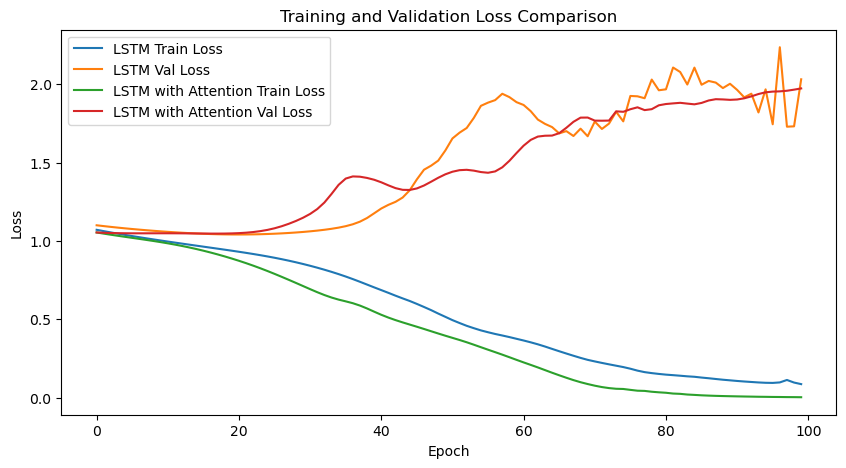

In [15]:
# 모델 학습
train_losses_lstm, val_losses_lstm = train_model(model_lstm, optimizer_lstm, x_train, y_train, x_val, y_val, num_epochs)
train_losses_attention, val_losses_attention = train_model(model_attention, optimizer_attention, x_train, y_train, x_val, y_val, num_epochs)

# 테스트 손실 계산
def test_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    return test_loss.item()

test_loss_lstm = test_model(model_lstm, x_test, y_test)
test_loss_attention = test_model(model_attention, x_test, y_test)

print(f'Test Loss for LSTM: {test_loss_lstm:.4f}')
print(f'Test Loss for LSTM with Attention: {test_loss_attention:.4f}')

# 학습 및 검증 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lstm, label='LSTM Train Loss')
plt.plot(val_losses_lstm, label='LSTM Val Loss')
plt.plot(train_losses_attention, label='LSTM with Attention Train Loss')
plt.plot(val_losses_attention, label='LSTM with Attention Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

# 설명추가

In [ ]:
# 예제 LSTM 모듈
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)

# 더미 입력 데이터
x = torch.randn(32, 100, 10)  # (batch_size, seq_len, input_size)
h_0 = torch.zeros(2, 32, 20)  # (num_layers, batch_size, hidden_size)
c_0 = torch.zeros(2, 32, 20)  # (num_layers, batch_size, hidden_size)

# LSTM 레이어를 통과시킴
h, (h_n, c_n) = lstm(x, (h_0, c_0))

print(h.shape)    # (32, 100, 20): 모든 타임스텝의 은닉 상태
print(h_n.shape)  # (2, 32, 20): 마지막 타임스텝의 은닉 상태
print(c_n.shape)  # (2, 32, 20): 마지막 타임스텝의 셀 상태

In [ ]:
1

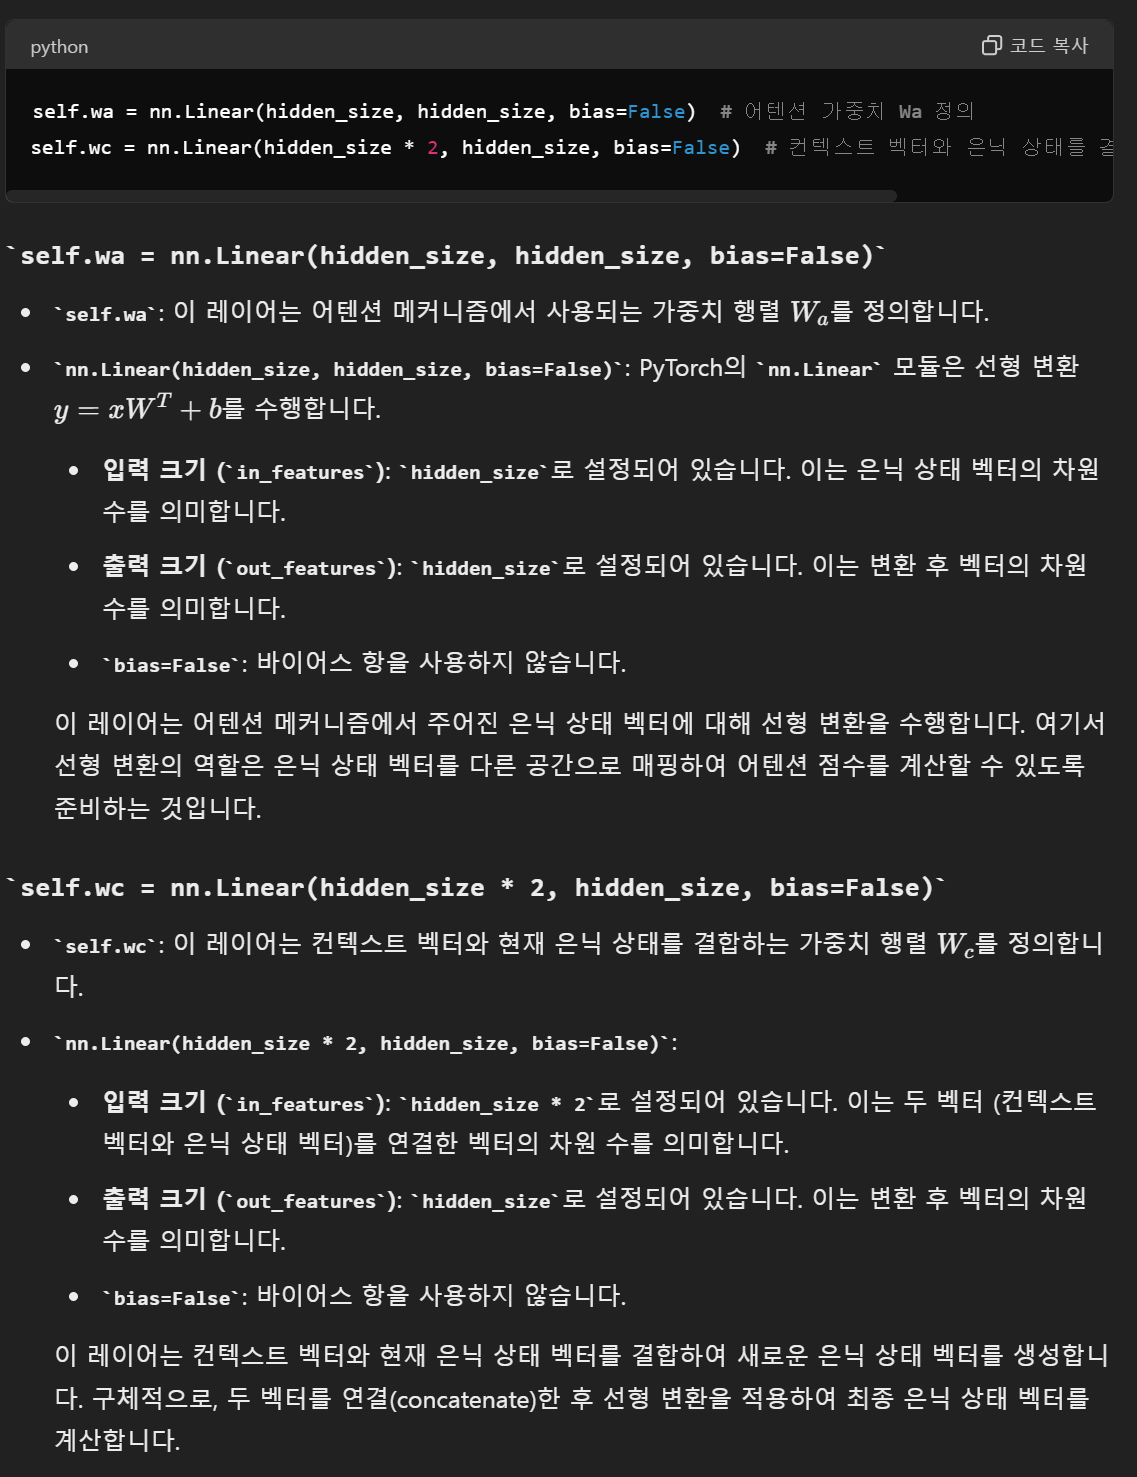
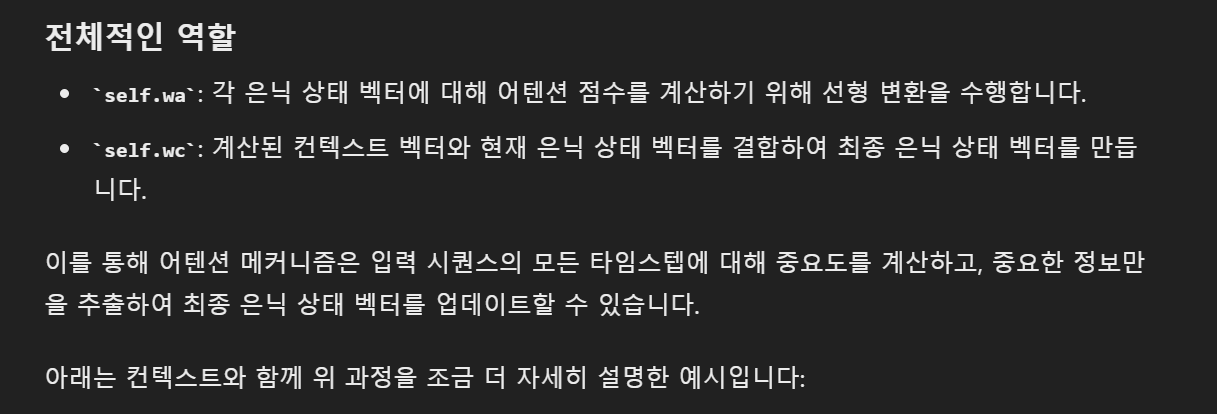
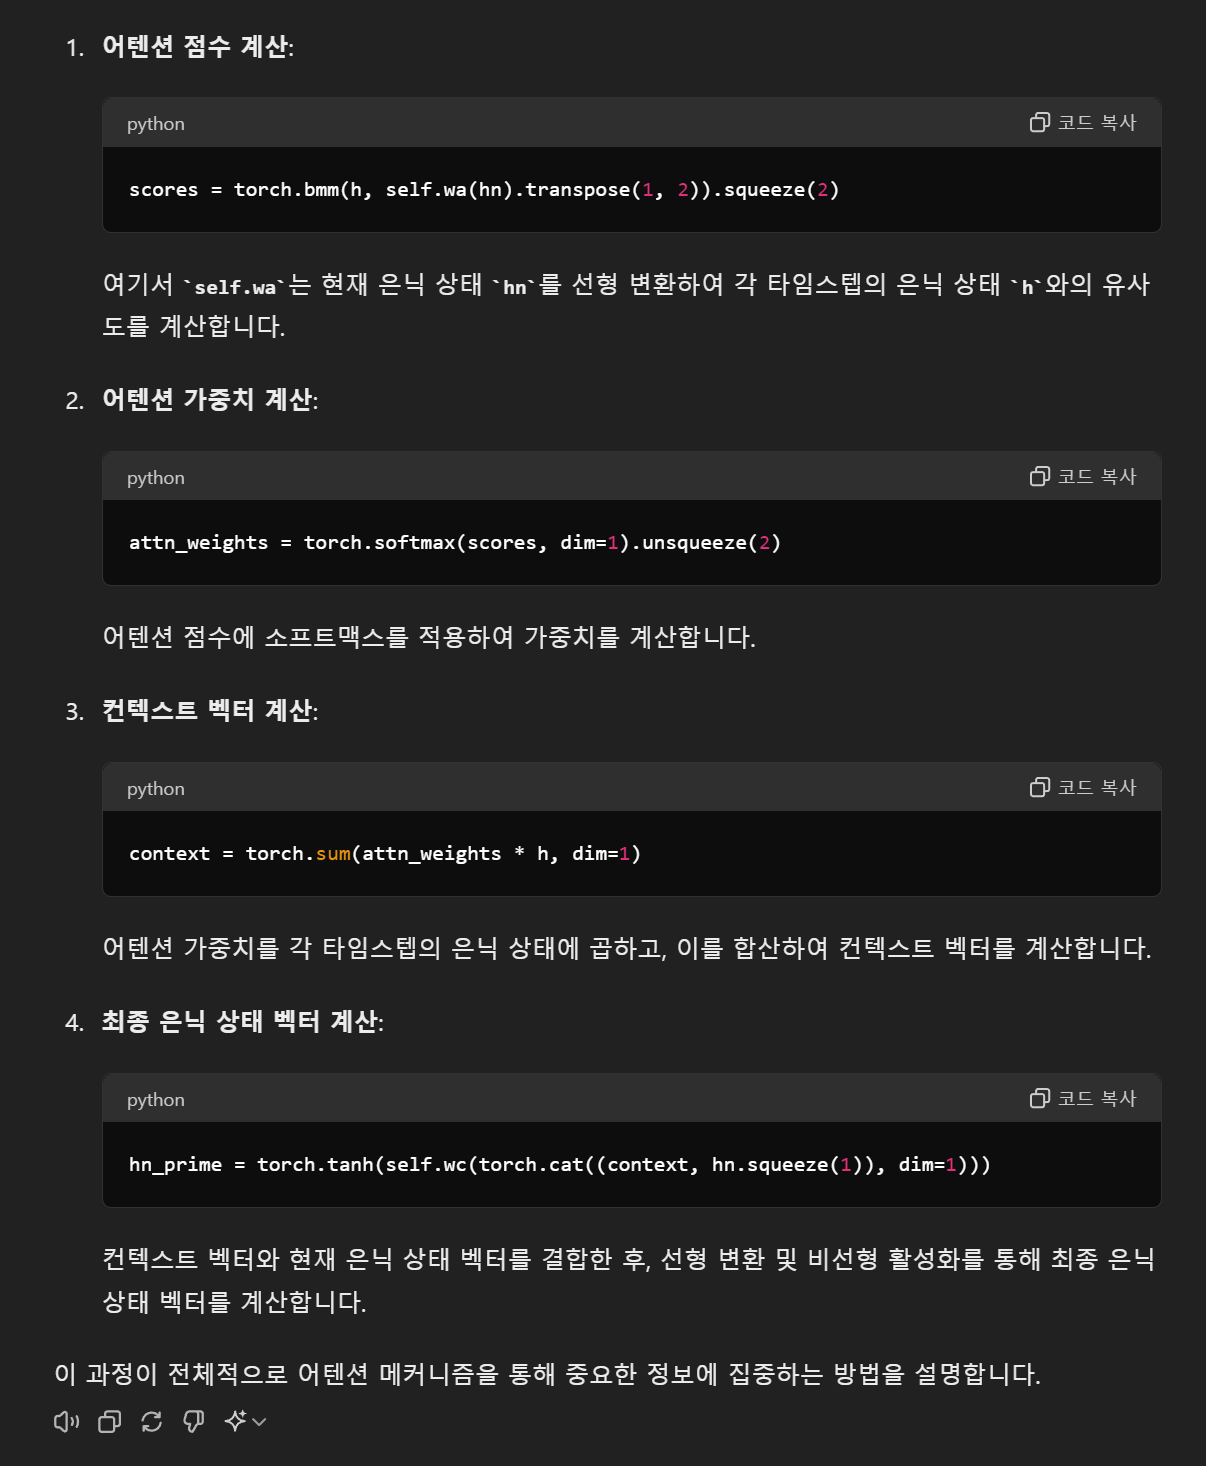